# E-commerce recommender system

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings('ignore')

### Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("malaiarasugraj/e-commerce-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ryan\.cache\kagglehub\datasets\malaiarasugraj\e-commerce-dataset\versions\1


### Data read and preprocessing

In [3]:
def data_read(path):
    """
    Read data from the downloaded dataset path
    """
    import os
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the dataset directory")
    
    file_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(file_path)
    return df

In [4]:
path = kagglehub.dataset_download("malaiarasugraj/e-commerce-dataset")
df = data_read(path)

print("\nFirst 5 rows of the dataset:")
display(df.head())


First 5 rows of the dataset:


Product ID Product Name     Category    Price  Discount  Tax Rate  \
0      P6879       Jacket      Apparel    53.85         5        15   
1      P5132       Camera  Electronics   761.26        10        15   
2      P2941     Sneakers     Footwear  1756.76         5         8   
3      P8545    Cookbooks        Books   295.24        10        15   
4      P4594       Camera  Electronics   832.00        10        12   

   Stock Level Supplier ID Customer Age Group Customer Location  \
0          150        S535              35-44     New York, USA   
1          224        S583              25-34        London, UK   
2          468        S118              25-34      Tokyo, Japan   
3           25        S104              18-24     Paris, France   
4          340        S331                55+      Tokyo, Japan   

  Customer Gender  Shipping Cost Shipping Method  Return Rate Seasonality  \
0            Male          23.32        Standard         4.49         Yes   
1          Female          20.88       Overnight        16.11          No   
2      Non-Binary          16.43        Standard         4.93          No   
3          Female          27.49        Standard         1.31          No   
4            Male          45.93       Overnight         4.37          No   

   Popularity Index  
0                56  
1                79  
2                40  
3                93  
4                56

In [5]:
def preprocess_data(df):
    """
    Preprocess the data for clustering and PCA
    """
    df_processed = df.copy()
    
    # Handle categorical variables
    categorical_columns = ['Category', 'Customer Age Group', 'Customer Location', 
                          'Customer Gender', 'Shipping Method', 'Seasonality']
    
    # Label encode categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
    
    # Select numerical features for clustering and PCA
    numerical_features = ['Price', 'Discount', 'Tax Rate', 'Stock Level', 
                         'Shipping Cost', 'Return Rate', 'Popularity Index']
    
    # Add encoded categorical features
    encoded_features = [col for col in df_processed.columns if col.endswith('_encoded')]
    all_features = numerical_features + encoded_features
    
    # Create feature matrix
    feature_matrix = df_processed[all_features].copy()
    
    # Handle any remaining missing values
    feature_matrix = feature_matrix.fillna(feature_matrix.mean())
    
    return df_processed, feature_matrix, all_features

In [6]:
df_processed, feature_matrix, feature_names = preprocess_data(df)
print(f"Processed dataset shape: {df_processed.shape}")
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Features used: {feature_names}")

Processed dataset shape: (1000000, 22)
Feature matrix shape: (1000000, 13)
Features used: ['Price', 'Discount', 'Tax Rate', 'Stock Level', 'Shipping Cost', 'Return Rate', 'Popularity Index', 'Category_encoded', 'Customer Age Group_encoded', 'Customer Location_encoded', 'Customer Gender_encoded', 'Shipping Method_encoded', 'Seasonality_encoded']


In [7]:
print(f"DATASET DIMENSIONS:")
print(f"Rows (samples): {df.shape[0]:,}")
print(f"Columns (features): {df.shape[1]}")

DATASET DIMENSIONS:
Rows (samples): 1,000,000
Columns (features): 16


### PCA

In [8]:
def pca_analysis(feature_matrix, n_components=2):
    """
    Perform PCA dimensionality reduction
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(scaled_features)
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        pca_features, 
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")
    
    return pca_df, pca, scaler

In [9]:
df_without_pca = df_processed.copy()
pca_df, pca_model, scaler = pca_analysis(feature_matrix)
df_with_pca = pd.concat([df_processed.reset_index(drop=True), pca_df], axis=1)

print(f"\nOriginal feature matrix shape: {feature_matrix.shape}")
print(f"PCA-reduced features shape: {pca_df.shape}")

Explained variance ratio: [0.07731792 0.07726211]
Total explained variance: 0.155

Original feature matrix shape: (1000000, 13)
PCA-reduced features shape: (1000000, 2)


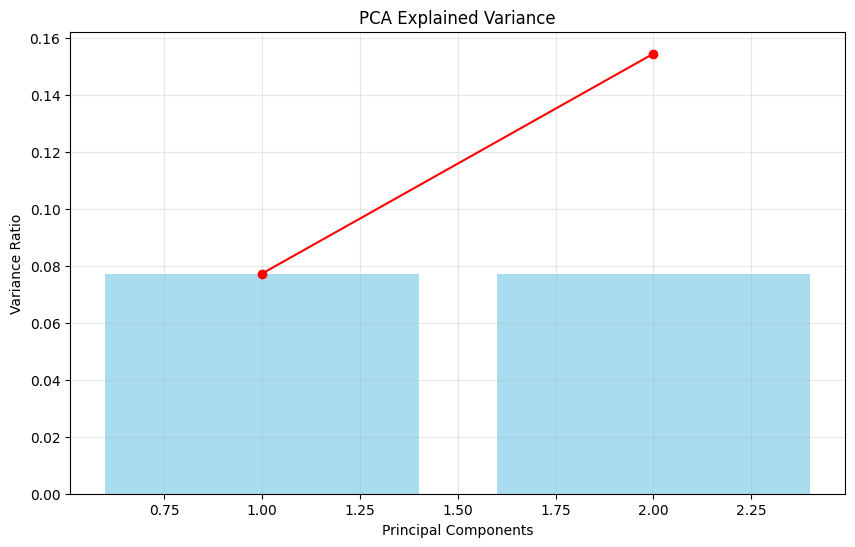

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 3), pca_model.explained_variance_ratio_, alpha=0.7, color='skyblue')
plt.plot(range(1, 3), np.cumsum(pca_model.explained_variance_ratio_), marker='o', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(alpha=0.3)
plt.show()

## Kmeans Point Clustering

### Customer clustering based on similar item preferences

In [11]:
# def customer_clustering(df, feature_matrix, pca_features=None):
#     """
#     Customer clustering
#     """
#     results = {}
    
#     # Method 1: Using original features
#     print("Clustering with original features...")
    
#     # Standardize
#     scaler = StandardScaler()
#     scaled_original = scaler.fit_transform(feature_matrix)
    
#     kmeans_original = KMeans(n_clusters=4, random_state=42, n_init=3, max_iter=50)
#     clusters_original = kmeans_original.fit_predict(scaled_original)
    
#     results['original'] = {
#         'clusters': clusters_original,
#         'model': kmeans_original,
#         'silhouette': silhouette_score(scaled_original, clusters_original),
#         'features': scaled_original
#     }
    
#     # Method 2: Using PCA features (if provided)
#     if pca_features is not None:
#         print("Clustering with PCA features...")
        
#         kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=3, max_iter=50)
#         clusters_pca = kmeans_pca.fit_predict(pca_features)
        
#         results['pca'] = {
#             'clusters': clusters_pca,
#             'model': kmeans_pca,
#             'silhouette': silhouette_score(pca_features, clusters_pca),
#             'features': pca_features
#         }
    
#     return results

In [12]:
# clusters_without_pca = customer_clustering(df_processed, feature_matrix)
# clusters_with_pca = customer_clustering(df_processed, feature_matrix, pca_df.values)

In [13]:
def quick_clustering_fixed_sample(feature_matrix, pca_features=None, sample_size=10000):
    """
    Clustering using fixed small sample
    """
    print(f"QUICK CLUSTERING WITH {sample_size:,} SAMPLE ROWS")
    
    # Take fixed sample
    sample_indices = np.random.choice(len(feature_matrix), size=sample_size, replace=False)
    feature_sample = feature_matrix.iloc[sample_indices] if hasattr(feature_matrix, 'iloc') else feature_matrix[sample_indices]
    
    scaler = StandardScaler()
    scaled_sample = scaler.fit_transform(feature_sample)
    
    # Very fast clustering
    kmeans_quick = KMeans(n_clusters=4, random_state=42, n_init=3, max_iter=20)
    clusters_sample = kmeans_quick.fit_predict(scaled_sample)
    
    results = {
        'original': {
            'clusters': clusters_sample,
            'model': kmeans_quick,
            'silhouette': silhouette_score(scaled_sample, clusters_sample),
            'sample_indices': sample_indices,
            'note': 'Clusters on sample only'
        }
    }
    
    return results

# Get immediate results
print("Getting immediate clustering results...")
quick_results = quick_clustering_fixed_sample(feature_matrix)
print("Quick clustering completed")

Getting immediate clustering results...
QUICK CLUSTERING WITH 10,000 SAMPLE ROWS


  File "C:\Users\Ryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Quick clustering completed


In [14]:
# from sklearn.cluster import MiniBatchKMeans

# def customer_clustering_minibatch(df, feature_matrix, pca_features=None):
#     """
#     MiniBatchKMeans
#     """
#     results = {}
    
#     print("Clustering with MiniBatchKMeans (original features)...")
    
#     scaler = StandardScaler()
#     scaled_original = scaler.fit_transform(feature_matrix)

#     mbkmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100, max_iter=50)
#     clusters_original = mbkmeans.fit_predict(scaled_original)
    
#     results['original'] = {
#         'clusters': clusters_original,
#         'model': mbkmeans,
#         'silhouette': silhouette_score(scaled_original, clusters_original),
#         'features': scaled_original
#     }
    
#     if pca_features is not None:
#         print("Clustering with MiniBatchKMeans (PCA features)...")
        
#         mbkmeans_pca = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=100, max_iter=50)
#         clusters_pca = mbkmeans_pca.fit_predict(pca_features)
        
#         results['pca'] = {
#             'clusters': clusters_pca,
#             'model': mbkmeans_pca,
#             'silhouette': silhouette_score(pca_features, clusters_pca),
#             'features': pca_features
#         }
    
#     return results

In [15]:
# print(f"Starting MiniBatchKMeans clustering...")
# clusters_without_pca = customer_clustering_minibatch(df_processed, feature_matrix)
# clusters_with_pca = customer_clustering_minibatch(df_processed, feature_matrix, pca_df.values)
# print("MiniBatchKMeans clustering completed!")

In [16]:
def customer_clustering_sampled(df, feature_matrix, pca_features=None, sample_size=10000):
    """
    Customer clustering using sampled data for faster execution
    """
    results = {}
    
    sample_indices = np.random.choice(len(feature_matrix), size=sample_size, replace=False)
    
    # Method 1: Using original features
    print("Customer Clustering with sampled data (original features)...")
    
    scaler = StandardScaler()
    scaled_sample = scaler.fit_transform(feature_matrix.iloc[sample_indices])
    
    kmeans_sample = KMeans(n_clusters=4, random_state=42, n_init=5, max_iter=100)
    clusters_sample = kmeans_sample.fit_predict(scaled_sample)
    
    # Apply to full dataset using predict
    scaled_full = scaler.transform(feature_matrix)
    clusters_full = kmeans_sample.predict(scaled_full)
    
    results['original'] = {
        'clusters': clusters_full,
        'sample_clusters': clusters_sample,
        'model': kmeans_sample,
        'silhouette': silhouette_score(scaled_sample, clusters_sample),
        'sample_indices': sample_indices,
        'sample_size': sample_size
    }
    
    # Method 2: Using PCA features (if provided)
    if pca_features is not None:
        print("Customer Clustering with sampled data (PCA features)...")
        
        pca_sample = pca_features[sample_indices]
        
        kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=5, max_iter=100)
        clusters_pca_sample = kmeans_pca.fit_predict(pca_sample)
        
        # Apply to full PCA dataset
        clusters_pca_full = kmeans_pca.predict(pca_features)
        
        results['pca'] = {
            'clusters': clusters_pca_full,
            'sample_clusters': clusters_pca_sample,
            'model': kmeans_pca,
            'silhouette': silhouette_score(pca_sample, clusters_pca_sample),
            'sample_indices': sample_indices,
            'sample_size': sample_size
        }
    
    return results

In [17]:
print("Starting Customer Clustering with 10,000 sample...")

clusters_without_pca = customer_clustering_sampled(df_processed, feature_matrix)
print("Customer clustering with original features completed!")

clusters_with_pca = customer_clustering_sampled(df_processed, feature_matrix, pca_df.values)
print("Customer clustering with PCA features completed!")

Starting Customer Clustering with 10,000 sample...
Customer Clustering with sampled data (original features)...
Customer clustering with original features completed!
Customer Clustering with sampled data (original features)...
Customer Clustering with sampled data (PCA features)...
Customer clustering with PCA features completed!


### Item clustering based on items likely purchased together

In [18]:
# def item_clustering(df, feature_matrix, pca_features=None):
#     """
#     Item clustering
#     """
#     results = {}
    
#     # Original features clustering
#     scaler = StandardScaler()
#     scaled_items = scaler.fit_transform(feature_matrix)
    
#     kmeans_items = KMeans(n_clusters=4, random_state=42, n_init=3, max_iter=50)
#     item_clusters_original = kmeans_items.fit_predict(scaled_items)
    
#     results['original'] = {
#         'clusters': item_clusters_original,
#         'model': kmeans_items,
#         'silhouette': silhouette_score(scaled_items, item_clusters_original)
#     }
    
#     # PCA features clustering
#     if pca_features is not None:
#         kmeans_items_pca = KMeans(n_clusters=3, random_state=42, n_init=3, max_iter=50)
#         item_clusters_pca = kmeans_items_pca.fit_predict(pca_features)
        
#         results['pca'] = {
#             'clusters': item_clusters_pca,
#             'model': kmeans_items_pca,
#             'silhouette': silhouette_score(pca_features, item_clusters_pca)
#         }
    
#     return results

In [19]:
# item_clusters_without_pca = item_clustering(df_processed, feature_matrix)
# item_clusters_with_pca = item_clustering(df_processed, feature_matrix, pca_df.values)

In [20]:
# def item_clustering_minibatch(df, feature_matrix, pca_features=None):
#     """
#     Use MiniBatchKMeans for item clustering - faster and avoids parallel processing issues
#     """
#     results = {}
    
#     print("Item Clustering with MiniBatchKMeans (original features)...")
    
#     # For item clustering, we'll focus on product features
#     scaler = StandardScaler()
#     scaled_items = scaler.fit_transform(feature_matrix)
    
#     # Use MiniBatchKMeans for items
#     mbkmeans_items = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=100, max_iter=100, n_init=3)
#     item_clusters_original = mbkmeans_items.fit_predict(scaled_items)
    
#     results['original'] = {
#         'clusters': item_clusters_original,
#         'model': mbkmeans_items,
#         'silhouette': silhouette_score(scaled_items, item_clusters_original)
#     }
    
#     if pca_features is not None:
#         print("Item Clustering with MiniBatchKMeans (PCA features)...")
        
#         mbkmeans_items_pca = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=100, max_iter=100, n_init=3)
#         item_clusters_pca = mbkmeans_items_pca.fit_predict(pca_features)
        
#         results['pca'] = {
#             'clusters': item_clusters_pca,
#             'model': mbkmeans_items_pca,
#             'silhouette': silhouette_score(pca_features, item_clusters_pca)
#         }
    
#     return results

In [21]:
# print(f"Starting MiniBatchKMeans Item Clustering...")
# item_clusters_without_pca = item_clustering_minibatch(df_processed, feature_matrix)
# print("Item clustering with original features completed!")
# item_clusters_with_pca = item_clustering_minibatch(df_processed, feature_matrix, pca_df.values)
# print("Item clustering with PCA features completed!")

In [22]:
def item_clustering_sampled(df, feature_matrix, pca_features=None, sample_size=10000):
    """
    Item clustering using sampled data for faster execution
    """
    results = {}
    
    sample_indices = np.random.choice(len(feature_matrix), size=sample_size, replace=False)
    
    # Method 1: Using original features
    print("Item Clustering with sampled data (original features)...")
    
    scaler = StandardScaler()
    scaled_sample = scaler.fit_transform(feature_matrix.iloc[sample_indices])
    
    kmeans_items = KMeans(n_clusters=5, random_state=42, n_init=5, max_iter=100)
    item_clusters_sample = kmeans_items.fit_predict(scaled_sample)
    
    # Apply to full dataset
    scaled_full = scaler.transform(feature_matrix)
    item_clusters_full = kmeans_items.predict(scaled_full)
    
    results['original'] = {
        'clusters': item_clusters_full,
        'sample_clusters': item_clusters_sample,
        'model': kmeans_items,
        'silhouette': silhouette_score(scaled_sample, item_clusters_sample),
        'sample_indices': sample_indices,
        'sample_size': sample_size
    }
    
    # Method 2: Using PCA features (if provided)
    if pca_features is not None:
        print("Item Clustering with sampled data (PCA features)...")
        
        pca_sample = pca_features[sample_indices]
        
        kmeans_items_pca = KMeans(n_clusters=4, random_state=42, n_init=5, max_iter=100)
        item_clusters_pca_sample = kmeans_items_pca.fit_predict(pca_sample)
        
        # Apply to full PCA dataset
        item_clusters_pca_full = kmeans_items_pca.predict(pca_features)
        
        results['pca'] = {
            'clusters': item_clusters_pca_full,
            'sample_clusters': item_clusters_pca_sample,
            'model': kmeans_items_pca,
            'silhouette': silhouette_score(pca_sample, item_clusters_pca_sample),
            'sample_indices': sample_indices,
            'sample_size': sample_size
        }
    
    return results

In [23]:
print("Starting Item Clustering with 10,000 sample...")

item_clusters_without_pca = item_clustering_sampled(df_processed, feature_matrix)
print("Item clustering with original features completed!")

item_clusters_with_pca = item_clustering_sampled(df_processed, feature_matrix, pca_df.values)
print("Item clustering with PCA features completed!")

Starting Item Clustering with 10,000 sample...
Item Clustering with sampled data (original features)...
Item clustering with original features completed!
Item Clustering with sampled data (original features)...
Item Clustering with sampled data (PCA features)...
Item clustering with PCA features completed!


In [24]:
df_without_pca['customer_cluster'] = clusters_without_pca['original']['clusters']
df_without_pca['item_cluster'] = item_clusters_without_pca['original']['clusters']

df_with_pca['customer_cluster'] = clusters_with_pca['pca']['clusters']
df_with_pca['item_cluster'] = item_clusters_with_pca['pca']['clusters']

print("Cluster labels added to datasets:")
print(f"Without PCA - Customer clusters: {df_without_pca['customer_cluster'].nunique()}")
print(f"Without PCA - Item clusters: {df_without_pca['item_cluster'].nunique()}")
print(f"With PCA - Customer clusters: {df_with_pca['customer_cluster'].nunique()}")
print(f"With PCA - Item clusters: {df_with_pca['item_cluster'].nunique()}")

Cluster labels added to datasets:
Without PCA - Customer clusters: 4
Without PCA - Item clusters: 5
With PCA - Customer clusters: 3
With PCA - Item clusters: 4


### Clustering Visualizations

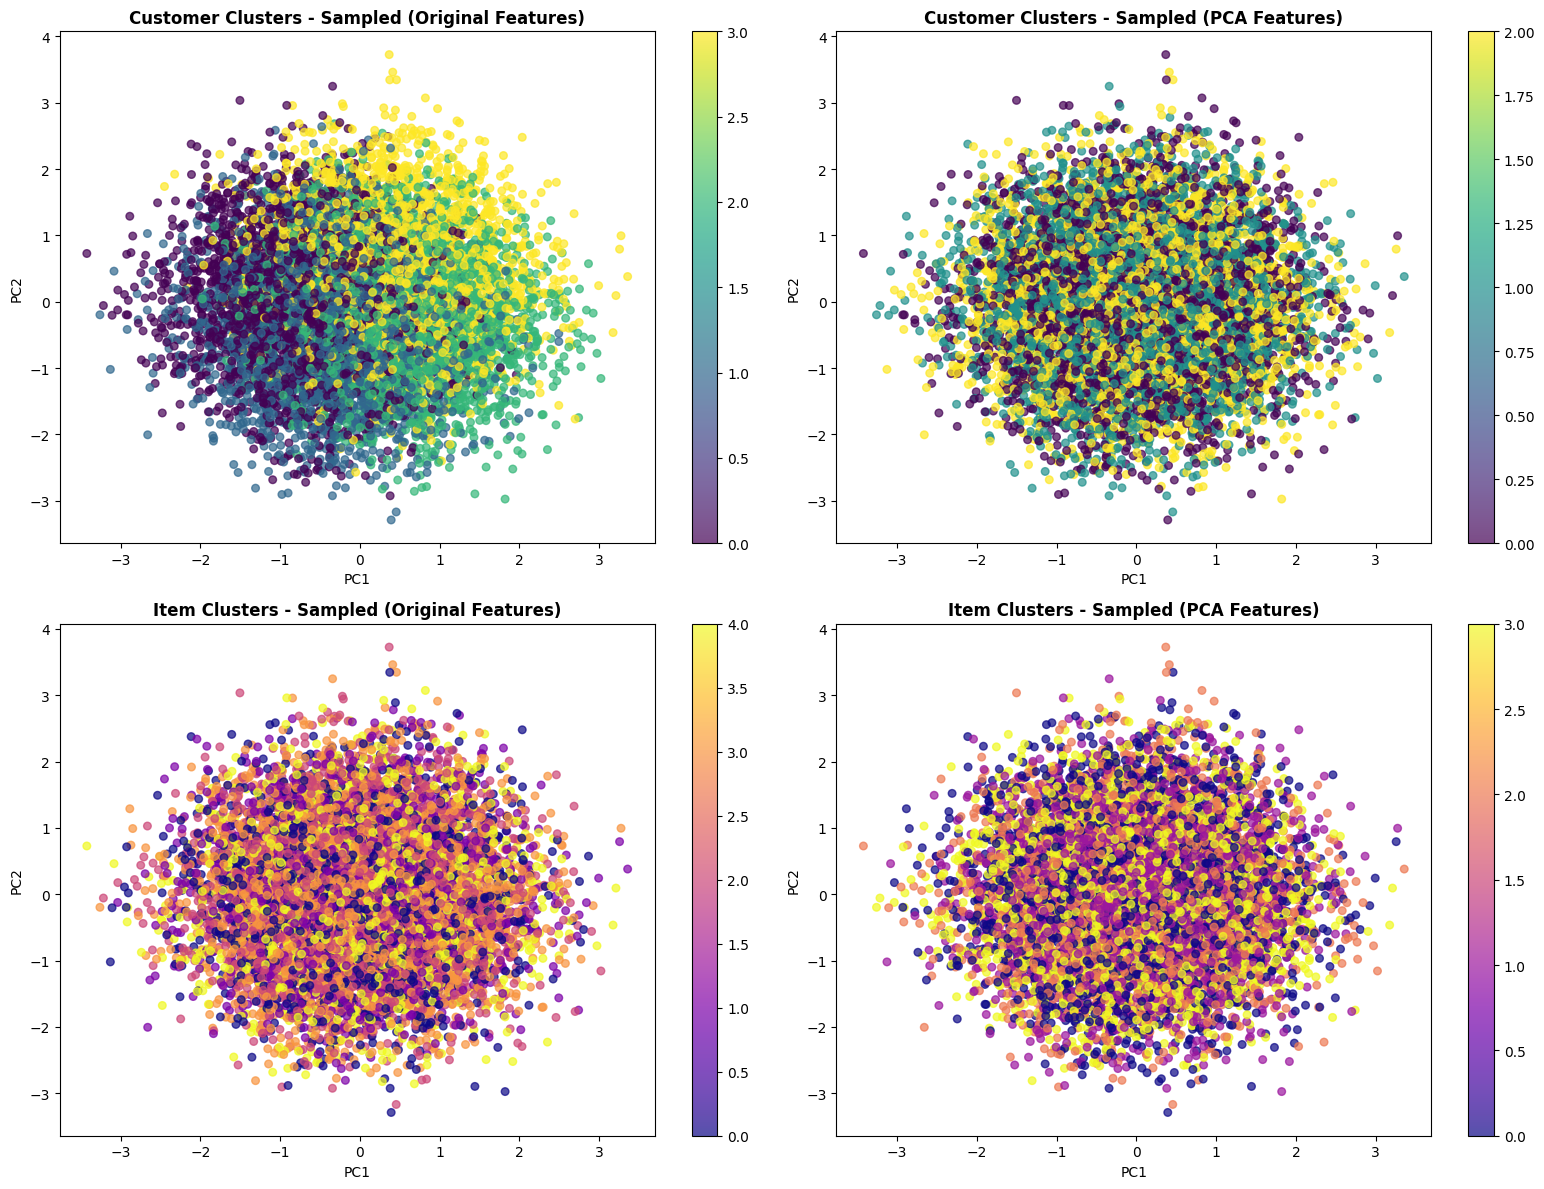

In [25]:
sample_indices = clusters_without_pca['original']['sample_indices']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Customer clusters with original features (sample only)
scatter1 = axes[0,0].scatter(pca_df.iloc[sample_indices]['PC1'], 
                            pca_df.iloc[sample_indices]['PC2'], 
                            c=clusters_without_pca['original']['sample_clusters'], 
                            cmap='viridis', alpha=0.7, s=30)
axes[0,0].set_title('Customer Clusters - Sampled (Original Features)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0,0])

# Customer clusters with PCA features (sample only)
scatter2 = axes[0,1].scatter(pca_df.iloc[sample_indices]['PC1'], 
                            pca_df.iloc[sample_indices]['PC2'], 
                            c=clusters_with_pca['pca']['sample_clusters'], 
                            cmap='viridis', alpha=0.7, s=30)
axes[0,1].set_title('Customer Clusters - Sampled (PCA Features)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('PC1')
axes[0,1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[0,1])

# Item clusters with original features (sample only)
scatter3 = axes[1,0].scatter(pca_df.iloc[sample_indices]['PC1'], 
                            pca_df.iloc[sample_indices]['PC2'], 
                            c=item_clusters_without_pca['original']['sample_clusters'], 
                            cmap='plasma', alpha=0.7, s=30)
axes[1,0].set_title('Item Clusters - Sampled (Original Features)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[1,0])

# Item clusters with PCA features (sample only)
scatter4 = axes[1,1].scatter(pca_df.iloc[sample_indices]['PC1'], 
                            pca_df.iloc[sample_indices]['PC2'], 
                            c=item_clusters_with_pca['pca']['sample_clusters'], 
                            cmap='plasma', alpha=0.7, s=30)
axes[1,1].set_title('Item Clusters - Sampled (PCA Features)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('PC1')
axes[1,1].set_ylabel('PC2')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

## Hierarchical Clustering

### Euclidean Agglomerative Clustering

In [26]:
def hierarchical_clustering_analysis(feature_matrix, pca_features=None, sample_size=10000, n_clusters=4):
    """
    Perform hierarchical clustering on both original and PCA features
    """
    results = {}
    
    # Sample the data for hierarchical clustering (slower algorithm)
    sample_indices = np.random.choice(len(feature_matrix), size=sample_size, replace=False)
    feature_sample = feature_matrix.iloc[sample_indices] if hasattr(feature_matrix, 'iloc') else feature_matrix[sample_indices]
    
    # Method 1: Hierarchical clustering on original features
    print("Hierarchical Clustering with original features...")
    
    scaler = StandardScaler()
    scaled_sample = scaler.fit_transform(feature_sample)
    
    # Hierarchical clustering
    hierarchical_orig = AgglomerativeClustering(
        n_clusters=n_clusters, 
        metric='euclidean', 
        linkage='ward'
    )
    hierarchical_labels_orig = hierarchical_orig.fit_predict(scaled_sample)

    
    # Apply to full dataset using KNN (approximation)
    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(scaled_sample)
    scaled_full = scaler.transform(feature_matrix)
    _, indices = knn.kneighbors(scaled_full)
    hierarchical_full_orig = hierarchical_labels_orig[indices.flatten()]
    
    results['original'] = {
        'sample_labels': hierarchical_labels_orig,
        'full_labels': hierarchical_full_orig,
        'model': hierarchical_orig,
        'silhouette': silhouette_score(scaled_sample, hierarchical_labels_orig),
        'sample_indices': sample_indices
    }
    
    # Method 2: Hierarchical clustering on PCA features
    if pca_features is not None:
        print("Hierarchical Clustering with PCA features...")
        
        pca_sample = pca_features[sample_indices]
        
        hierarchical_pca = AgglomerativeClustering(
            n_clusters=n_clusters-1,  # Fewer clusters for reduced dimensions
            metric='euclidean', 
            linkage='ward'
        )
        hierarchical_labels_pca = hierarchical_pca.fit_predict(pca_sample)
        
        # Apply to full PCA dataset
        knn_pca = NearestNeighbors(n_neighbors=1)
        knn_pca.fit(pca_sample)
        _, indices_pca = knn_pca.kneighbors(pca_features)
        hierarchical_full_pca = hierarchical_labels_pca[indices_pca.flatten()]
        
        results['pca'] = {
            'sample_labels': hierarchical_labels_pca,
            'full_labels': hierarchical_full_pca,
            'model': hierarchical_pca,
            'silhouette': silhouette_score(pca_sample, hierarchical_labels_pca),
            'sample_indices': sample_indices
        }
    
    return results

In [27]:
# Customer clustering with hierarchical
hierarchical_customer_orig = hierarchical_clustering_analysis(feature_matrix, n_clusters=4)
hierarchical_customer_pca = hierarchical_clustering_analysis(feature_matrix, pca_df.values, n_clusters=3)

Hierarchical Clustering with original features...
Hierarchical Clustering with original features...
Hierarchical Clustering with PCA features...


In [28]:
# Item clustering with hierarchical 
hierarchical_item_orig = hierarchical_clustering_analysis(feature_matrix, n_clusters=5)
hierarchical_item_pca = hierarchical_clustering_analysis(feature_matrix, pca_df.values, n_clusters=4)

Hierarchical Clustering with original features...
Hierarchical Clustering with original features...
Hierarchical Clustering with PCA features...


## Point vs Hierarchical Clustering Comparison

In [29]:
def compare_clustering_algorithms(kmeans_results, hierarchical_results, algorithm_name):
    """
    Compare K-Means and Hierarchical clustering performance
    """
    print(f"\n{algorithm_name.upper()} - K-MEANS VS HIERARCHICAL COMPARISON")
    print("=" * 60)
    
    # Original features comparison
    kmeans_orig_silhouette = kmeans_results['original']['silhouette']
    hierarchical_orig_silhouette = hierarchical_results['original']['silhouette']
    
    print(f"ORIGINAL FEATURES:")
    print(f"  K-Means:      Silhouette = {kmeans_orig_silhouette:.4f}")
    print(f"  Hierarchical: Silhouette = {hierarchical_orig_silhouette:.4f}")
    
    if kmeans_orig_silhouette > hierarchical_orig_silhouette:
        print(f"K-Means performs better on original features")
    else:
        print(f"Hierarchical performs better on original features")
    
    # PCA features comparison
    if 'pca' in kmeans_results and 'pca' in hierarchical_results:
        kmeans_pca_silhouette = kmeans_results['pca']['silhouette']
        hierarchical_pca_silhouette = hierarchical_results['pca']['silhouette']
        
        print(f"\nPCA FEATURES:")
        print(f"K-Means:      Silhouette = {kmeans_pca_silhouette:.4f}")
        print(f"Hierarchical: Silhouette = {hierarchical_pca_silhouette:.4f}")
        
        if kmeans_pca_silhouette > hierarchical_pca_silhouette:
            print(f"K-Means performs better on PCA features")
        else:
            print(f"Hierarchical performs better on PCA features")

# Compare customer clustering
compare_clustering_algorithms(
    {'original': clusters_without_pca['original'], 'pca': clusters_with_pca['pca']},
    {'original': hierarchical_customer_orig['original'], 'pca': hierarchical_customer_pca['pca']},
    "customer clustering"
)

# Compare item clustering
compare_clustering_algorithms(
    {'original': item_clusters_without_pca['original'], 'pca': item_clusters_with_pca['pca']},
    {'original': hierarchical_item_orig['original'], 'pca': hierarchical_item_pca['pca']},
    "item clustering"
)


CUSTOMER CLUSTERING - K-MEANS VS HIERARCHICAL COMPARISON
ORIGINAL FEATURES:
  K-Means:      Silhouette = 0.0625
  Hierarchical: Silhouette = 0.0223
K-Means performs better on original features

PCA FEATURES:
K-Means:      Silhouette = 0.3354
Hierarchical: Silhouette = 0.2885
K-Means performs better on PCA features

ITEM CLUSTERING - K-MEANS VS HIERARCHICAL COMPARISON
ORIGINAL FEATURES:
  K-Means:      Silhouette = 0.0548
  Hierarchical: Silhouette = 0.0171
K-Means performs better on original features

PCA FEATURES:
K-Means:      Silhouette = 0.3147
Hierarchical: Silhouette = 0.2713
K-Means performs better on PCA features


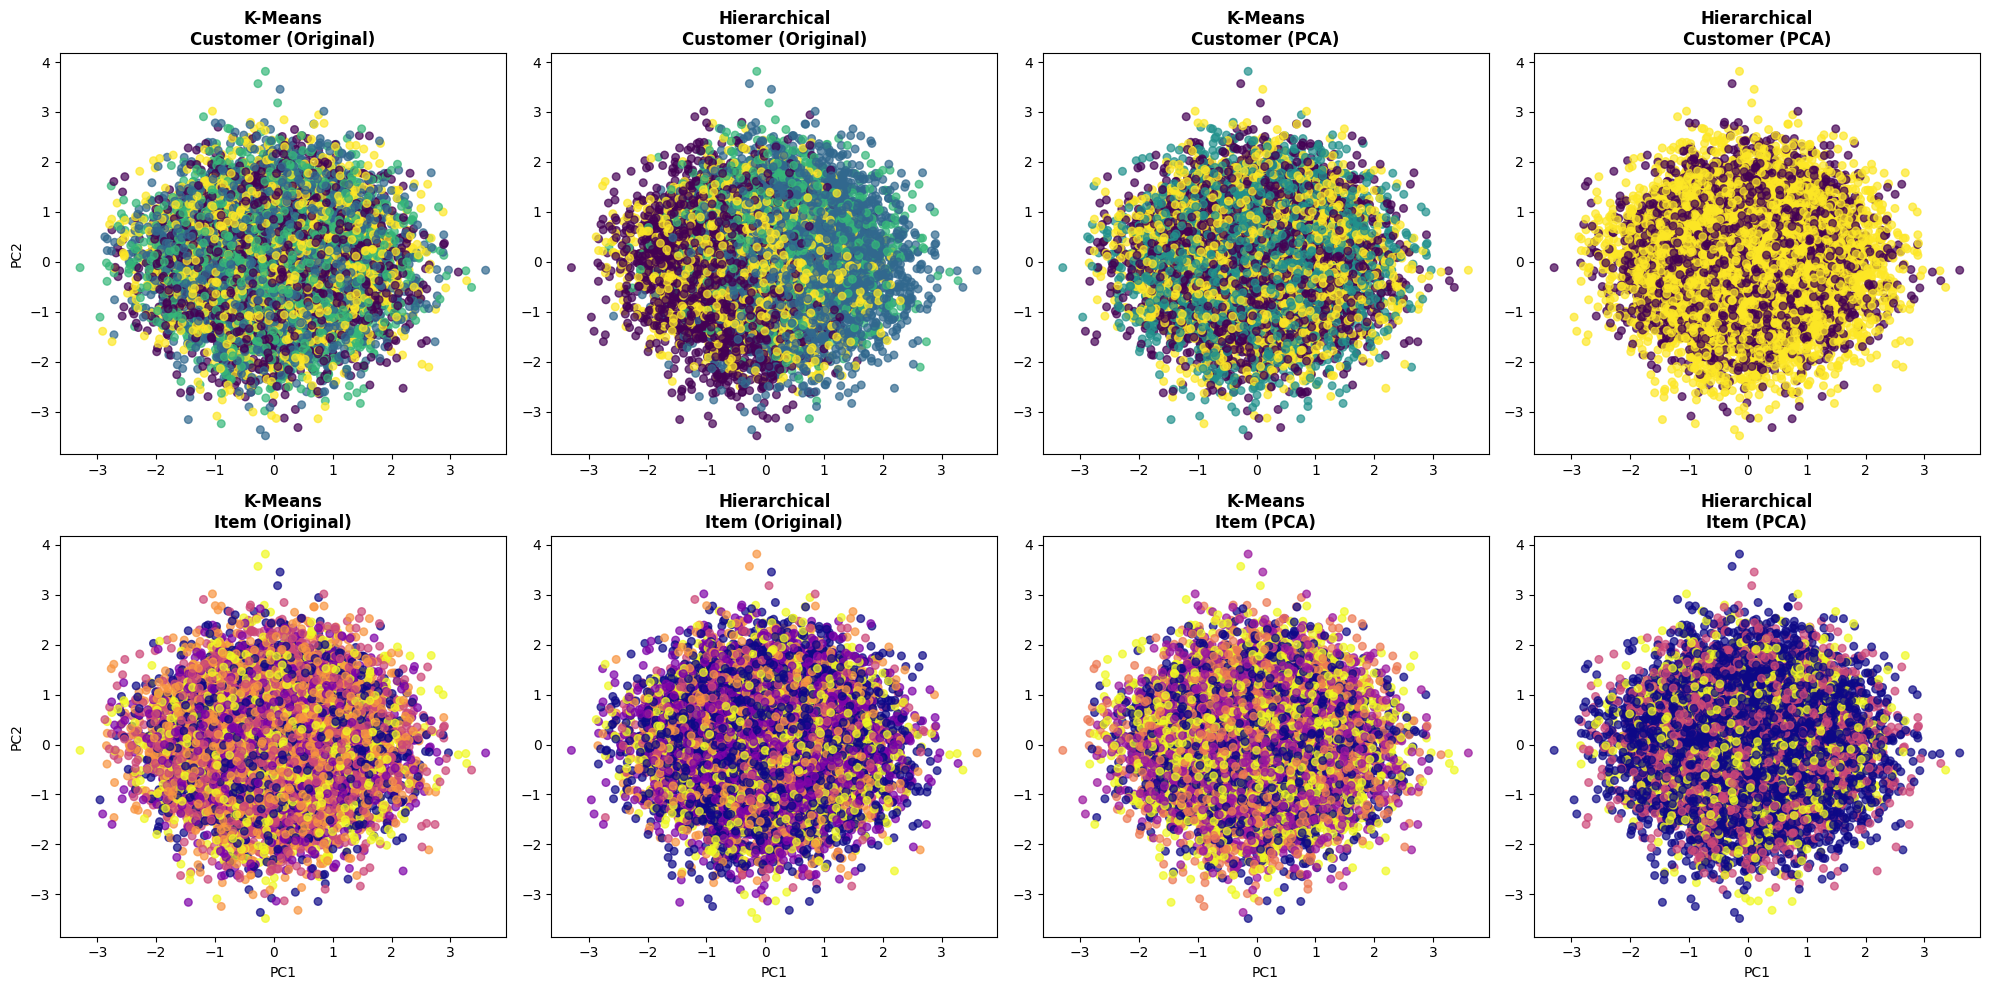

In [30]:
sample_indices = hierarchical_customer_orig['original']['sample_indices']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Customer Clustering Comparison
# K-Means - Original Features
scatter1 = axes[0,0].scatter(pca_df.iloc[sample_indices]['PC1'], 
                            pca_df.iloc[sample_indices]['PC2'],
                            c=clusters_without_pca['original']['sample_clusters'],
                            cmap='viridis', alpha=0.7, s=30)
axes[0,0].set_title('K-Means\nCustomer (Original)', fontweight='bold')
axes[0,0].set_ylabel('PC2')

# Hierarchical - Original Features
scatter2 = axes[0,1].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=hierarchical_customer_orig['original']['sample_labels'],
                            cmap='viridis', alpha=0.7, s=30)
axes[0,1].set_title('Hierarchical\nCustomer (Original)', fontweight='bold')

# K-Means - PCA Features
scatter3 = axes[0,2].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=clusters_with_pca['pca']['sample_clusters'],
                            cmap='viridis', alpha=0.7, s=30)
axes[0,2].set_title('K-Means\nCustomer (PCA)', fontweight='bold')

# Hierarchical - PCA Features
scatter4 = axes[0,3].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=hierarchical_customer_pca['pca']['sample_labels'],
                            cmap='viridis', alpha=0.7, s=30)
axes[0,3].set_title('Hierarchical\nCustomer (PCA)', fontweight='bold')

# Row 2: Item Clustering Comparison
# K-Means - Original Features
scatter5 = axes[1,0].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=item_clusters_without_pca['original']['sample_clusters'],
                            cmap='plasma', alpha=0.7, s=30)
axes[1,0].set_title('K-Means\nItem (Original)', fontweight='bold')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')

# Hierarchical - Original Features
scatter6 = axes[1,1].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=hierarchical_item_orig['original']['sample_labels'],
                            cmap='plasma', alpha=0.7, s=30)
axes[1,1].set_title('Hierarchical\nItem (Original)', fontweight='bold')
axes[1,1].set_xlabel('PC1')

# K-Means - PCA Features
scatter7 = axes[1,2].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=item_clusters_with_pca['pca']['sample_clusters'],
                            cmap='plasma', alpha=0.7, s=30)
axes[1,2].set_title('K-Means\nItem (PCA)', fontweight='bold')
axes[1,2].set_xlabel('PC1')

# Hierarchical - PCA Features
scatter8 = axes[1,3].scatter(pca_df.iloc[sample_indices]['PC1'],
                            pca_df.iloc[sample_indices]['PC2'],
                            c=hierarchical_item_pca['pca']['sample_labels'],
                            cmap='plasma', alpha=0.7, s=30)
axes[1,3].set_title('Hierarchical\nItem (PCA)', fontweight='bold')
axes[1,3].set_xlabel('PC1')

plt.tight_layout()
plt.show()

## Recommender Systems

### Content-based filtering

In [31]:
def content_based_recommendations(df, product_id, top_n=5, sample_size=10000):
    """
    Content-based filtering using sampling to avoid memory issues
    """
    print(f"Generating content-based recommendations (using {sample_size} sample)...")
    
    # Sample the dataset for faster computation
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        # Ensure the target product is in the sample
        if product_id not in df_sample['Product ID'].values:
            # Add the target product to the sample
            target_product = df[df['Product ID'] == product_id]
            df_sample = pd.concat([df_sample, target_product]).reset_index(drop=True)
    else:
        df_sample = df.copy().reset_index(drop=True)
    
    # Prepare features for content-based filtering
    features_for_cb = ['Category', 'Price', 'Customer Age Group', 'Customer Gender', 
                      'Popularity Index', 'Seasonality']
    
    # Only use features that exist in the dataframe
    available_features = [col for col in features_for_cb if col in df_sample.columns]
    
    # Create a feature string for each product
    df_sample['content_features'] = df_sample[available_features].astype(str).agg(' '.join, axis=1)
    
    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_sample['content_features'])
    
    # Compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get recommendations
    if product_id not in df_sample['Product ID'].values:
        print(f"Product ID {product_id} not found in dataset")
        return None
    
    idx = df_sample[df_sample['Product ID'] == product_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the product itself
    
    product_indices = [i[0] for i in sim_scores]
    recommendations = df_sample.iloc[product_indices][['Product ID', 'Product Name', 'Category', 'Price']]
    recommendations['similarity_score'] = [i[1] for i in sim_scores]
    
    print(f"Generated {len(recommendations)} recommendations from {len(df_sample)} products")
    return recommendations

### Collaborative filtering

In [32]:
def collaborative_filtering_recommendations(df, customer_profile, top_n=5, sample_size=10000):
    """
    Collaborative filtering with sampling to avoid memory overflow
    """
    print(f"Generating collaborative recommendations (using {sample_size} sample)...")
    
    # Sample the dataset
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    else:
        df_sample = df.copy().reset_index(drop=True)
    
    # Create customer feature vector
    customer_features = ['Customer Age Group', 'Customer Location', 'Customer Gender']
    available_features = [col for col in customer_features if col in df_sample.columns]
    
    # Encode customer profile and products
    le_dict = {}
    encoded_customer = []
    
    for feature in available_features:
        le = LabelEncoder()
        all_values = df_sample[feature].astype(str).tolist() + [customer_profile[feature]]
        le.fit(all_values)
        encoded_customer.append(le.transform([customer_profile[feature]])[0])
        le_dict[feature] = le
    
    # Encode product features for comparison
    product_vectors = []
    for _, row in df_sample.iterrows():
        product_vector = []
        for feature in available_features:
            product_vector.append(le_dict[feature].transform([str(row[feature])])[0])
        product_vectors.append(product_vector)
    
    product_vectors = np.array(product_vectors)
    customer_vector = np.array(encoded_customer).reshape(1, -1)
    
    # Find nearest products using KNN
    knn = NearestNeighbors(n_neighbors=top_n, metric='euclidean')
    knn.fit(product_vectors)
    distances, indices = knn.kneighbors(customer_vector)
    
    recommendations = df_sample.iloc[indices[0]][['Product ID', 'Product Name', 'Category', 'Price']]
    recommendations['match_score'] = 1 / (1 + distances[0])  # Convert distance to similarity score
    
    print(f"Generated {len(recommendations)} collaborative recommendations")
    return recommendations

### Hybrid filtering

In [33]:
def hybrid_recommendations(df, product_id, customer_profile, top_n=5):
    """
    Hybrid recommendations using sampling
    """
    print("Generating optimized hybrid recommendations...")
    
    # Get content-based recommendations
    content_recs = content_based_recommendations(df, product_id, top_n*2, sample_size=10000)
    
    # Get collaborative recommendations
    collab_recs = collaborative_filtering_recommendations(df, customer_profile, top_n*2, sample_size=10000)
    
    if content_recs is None or collab_recs is None:
        return None
    
    # Combine and rank recommendations
    hybrid_recs = pd.concat([content_recs, collab_recs]).drop_duplicates(subset=['Product ID'])
    
    # Simple hybrid scoring
    if 'similarity_score' in hybrid_recs.columns and 'match_score' in hybrid_recs.columns:
        hybrid_recs['hybrid_score'] = (hybrid_recs['similarity_score'].fillna(0) + 
                                     hybrid_recs['match_score'].fillna(0)) / 2
    else:
        available_scores = hybrid_recs[['similarity_score', 'match_score']].fillna(0)
        hybrid_recs['hybrid_score'] = available_scores.max(axis=1)
    
    hybrid_recs = hybrid_recs.nlargest(top_n, 'hybrid_score')
    
    print("Hybrid recommendations generated")
    return hybrid_recs

## Testing Recommender Systems

In [34]:
print("Testing recommender systems...")

# Sample product and customer for testing
sample_product_id = df['Product ID'].iloc[0]
sample_product_name = df[df['Product ID'] == sample_product_id]['Product Name'].iloc[0]
sample_customer = {
    'Customer Age Group': 'Adults',
    'Customer Location': 'United States', 
    'Customer Gender': 'Both'
}

print(f"\nTesting with product: {sample_product_name} (ID: {sample_product_id})")
print(f"Customer profile: {sample_customer}")

Testing recommender systems...

Testing with product: Jacket (ID: P6879)
Customer profile: {'Customer Age Group': 'Adults', 'Customer Location': 'United States', 'Customer Gender': 'Both'}


In [35]:
# Content-based recommendations
print("\n" + "="*50)
print("CONTENT-BASED RECOMMENDATIONS")
print("="*50)
content_recs = content_based_recommendations(df, sample_product_id)
if content_recs is not None:
    display(content_recs[['Product Name', 'Category', 'Price', 'similarity_score']].head())
else:
    print("No content-based recommendations generated")


CONTENT-BASED RECOMMENDATIONS
Generating content-based recommendations (using 10000 sample)...
Generated 5 recommendations from 10000 products


Product Name         Category    Price  similarity_score
2109    Microwave  Home Appliances  1568.98          0.574639
9472   Headphones      Electronics  1568.30          0.571716
2227        Socks          Apparel  1568.32          0.539820
2719        Dress          Apparel  1568.99          0.522997
3076       Camera      Electronics    74.50          0.484925

In [36]:
# Collaborative recommendations
print("\n" + "="*50)
print("COLLABORATIVE FILTERING RECOMMENDATIONS")
print("="*50)
collab_recs = collaborative_filtering_recommendations(df, sample_customer)
if collab_recs is not None:
    display(collab_recs[['Product Name', 'Category', 'Price', 'match_score']].head())
else:
    print("No collaborative filtering recommendations generated")


COLLABORATIVE FILTERING RECOMMENDATIONS
Generating collaborative recommendations (using 10000 sample)...
Generated 5 collaborative recommendations


Product Name         Category    Price  match_score
439       Smartwatch      Electronics  1746.22     0.366025
1767  Vacuum Cleaner  Home Appliances   835.17     0.366025
754            Heels         Footwear   682.83     0.366025
0          Magazines            Books  1522.61     0.366025
668    Running Shoes         Footwear   749.92     0.366025

In [37]:
# Hybrid recommendations
print("\n" + "="*50)
print("HYBRID RECOMMENDATIONS")
print("="*50)
hybrid_recs = hybrid_recommendations(df, sample_product_id, sample_customer)
if hybrid_recs is not None:
    display(hybrid_recs[['Product Name', 'Category', 'Price', 'hybrid_score']].head())
else:
    print("No hybrid recommendations generated")


HYBRID RECOMMENDATIONS
Generating optimized hybrid recommendations...
Generating content-based recommendations (using 10000 sample)...
Generated 10 recommendations from 10000 products
Generating collaborative recommendations (using 10000 sample)...
Generated 10 collaborative recommendations
Hybrid recommendations generated


Product Name         Category    Price  hybrid_score
2109    Microwave  Home Appliances  1568.98      0.287320
9472   Headphones      Electronics  1568.30      0.285858
2227        Socks          Apparel  1568.32      0.269910
2719        Dress          Apparel  1568.99      0.261498
3076       Camera      Electronics    74.50      0.242462

## Clustering Performance analysis

In [38]:
print("=" * 50)
print("CLUSTERING PERFORMANCE COMPARISON")
print("=" * 50)

# Prepare results for comparison
results_without_pca = {
    'original': clusters_without_pca['original'],
    'items': item_clusters_without_pca
}

results_with_pca = {
    'original': clusters_with_pca['pca'],
    'items': item_clusters_with_pca
}

# Compare customer clustering
if 'original' in results_without_pca and 'pca' in results_with_pca:
    orig_silhouette = results_without_pca['original']['silhouette']
    pca_silhouette = results_with_pca['original']['silhouette']
    
    print(f"Customer Clustering - Original Features Silhouette Score: {orig_silhouette:.4f}")
    print(f"Customer Clustering - PCA Features Silhouette Score: {pca_silhouette:.4f}")
    
    if orig_silhouette > pca_silhouette:
        print("Original features provide better customer clustering")
        improvement = ((orig_silhouette - pca_silhouette) / pca_silhouette) * 100
        print(f"  Improvement: {improvement:+.1f}%")
    else:
        print("PCA features provide better customer clustering")
        improvement = ((pca_silhouette - orig_silhouette) / orig_silhouette) * 100
        print(f"  Improvement: {improvement:+.1f}%")

# Compare item clustering
if 'original' in results_without_pca.get('items', {}) and 'pca' in results_with_pca.get('items', {}):
    orig_item_silhouette = results_without_pca['items']['original']['silhouette']
    pca_item_silhouette = results_with_pca['items']['original']['silhouette']
    
    print(f"\nItem Clustering - Original Features Silhouette: {orig_item_silhouette:.4f}")
    print(f"Item Clustering - PCA Features Silhouette: {pca_item_silhouette:.4f}")
    
    if orig_item_silhouette > pca_item_silhouette:
        print("Original features provide better item clustering")
        improvement = ((orig_item_silhouette - pca_item_silhouette) / pca_item_silhouette) * 100
        print(f"  Improvement: {improvement:+.1f}%")
    else:
        print("PCA features provide better item clustering")
        improvement = ((pca_item_silhouette - orig_item_silhouette) / orig_item_silhouette) * 100
        print(f"  Improvement: {improvement:+.1f}%")

CLUSTERING PERFORMANCE COMPARISON

Item Clustering - Original Features Silhouette: 0.0548
Item Clustering - PCA Features Silhouette: 0.0544
Original features provide better item clustering
  Improvement: +0.7%


## Results Visualization

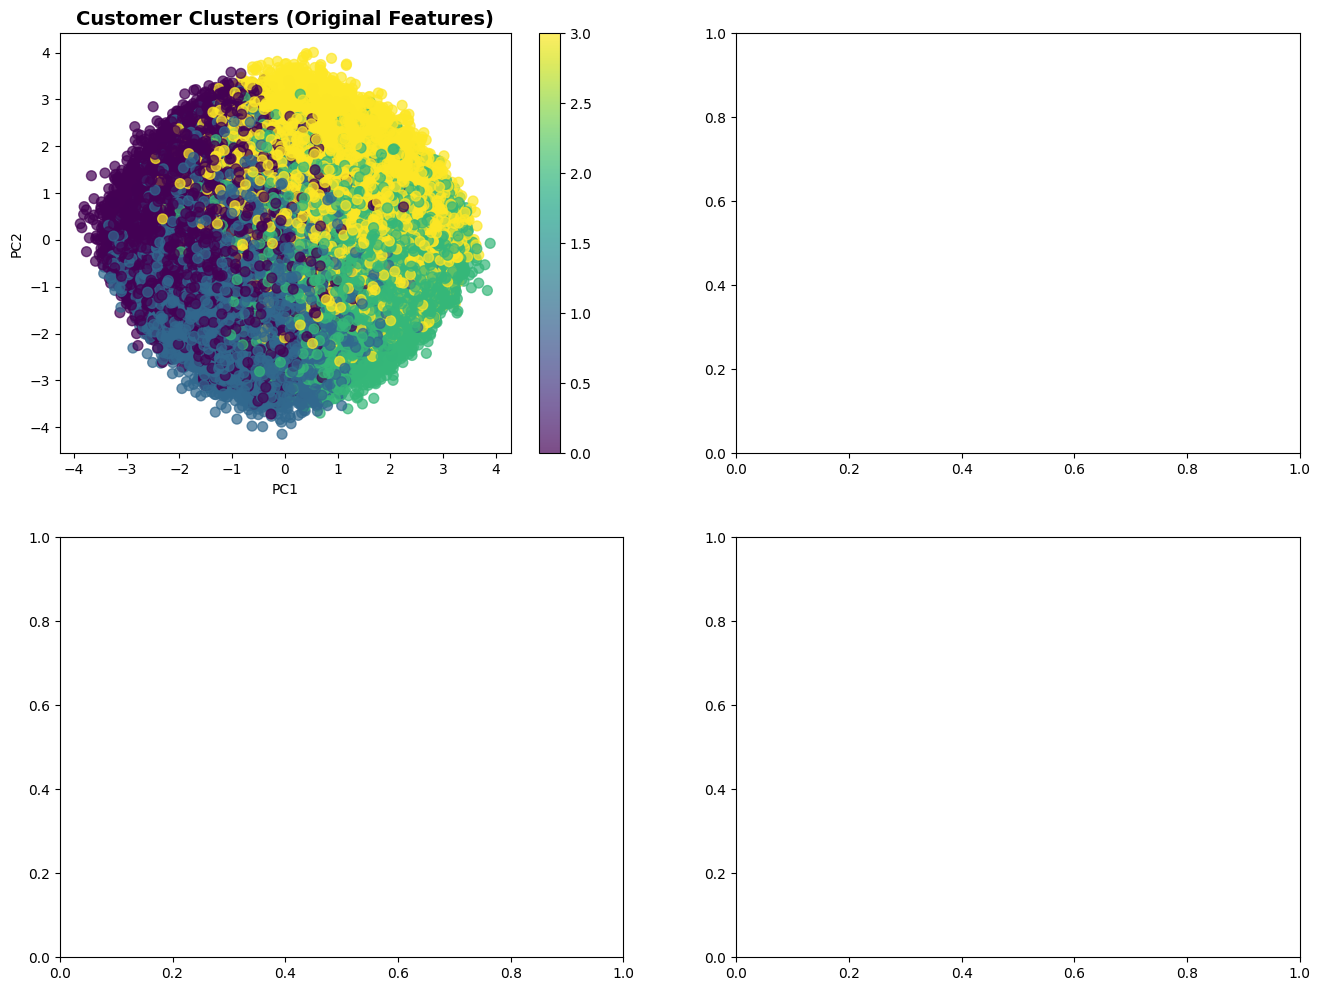

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Customer clusters with original features
scatter1 = axes[0,0].scatter(pca_df['PC1'], pca_df['PC2'], 
                            c=df_without_pca['customer_cluster'], cmap='viridis', alpha=0.7, s=50)
axes[0,0].set_title('Customer Clusters (Original Features)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0,0])

In [40]:
scatter2 = axes[0,1].scatter(pca_df['PC1'], pca_df['PC2'], 
                            c=df_with_pca['customer_cluster'], cmap='viridis', alpha=0.7, s=50)
axes[0,1].set_title('Customer Clusters (PCA Features)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('PC1')
axes[0,1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[0,1])

<Figure size 640x480 with 0 Axes>

In [41]:
scatter3 = axes[1,0].scatter(pca_df['PC1'], pca_df['PC2'], 
                            c=df_without_pca['item_cluster'], cmap='plasma', alpha=0.7, s=50)
axes[1,0].set_title('Item Clusters (Original Features)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[1,0])

<Figure size 640x480 with 0 Axes>

In [42]:
scatter4 = axes[1,1].scatter(pca_df['PC1'], pca_df['PC2'], 
                            c=df_with_pca['item_cluster'], cmap='plasma', alpha=0.7, s=50)
axes[1,1].set_title('Item Clusters (PCA Features)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('PC1')
axes[1,1].set_ylabel('PC2')
plt.colorbar(scatter4, ax=axes[1,1])

<Figure size 640x480 with 0 Axes>

In [43]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Cluster statistics

In [44]:
print("\n" + "="*50)
print("CLUSTER STATISTICS")
print("="*50)

print("\nCustomer Clusters (Original Features):")
customer_cluster_stats_orig = df_without_pca['customer_cluster'].value_counts().sort_index()
print(customer_cluster_stats_orig)

print("\nCustomer Clusters (PCA Features):")
customer_cluster_stats_pca = df_with_pca['customer_cluster'].value_counts().sort_index()
print(customer_cluster_stats_pca)

print("\nItem Clusters (Original Features):")
item_cluster_stats_orig = df_without_pca['item_cluster'].value_counts().sort_index()
print(item_cluster_stats_orig)

print("\nItem Clusters (PCA Features):")
item_cluster_stats_pca = df_with_pca['item_cluster'].value_counts().sort_index()
print(item_cluster_stats_pca)


CLUSTER STATISTICS

Customer Clusters (Original Features):
customer_cluster
0    250269
1    249934
2    250312
3    249485
Name: count, dtype: int64

Customer Clusters (PCA Features):
customer_cluster
0    328396
1    339246
2    332358
Name: count, dtype: int64

Item Clusters (Original Features):
item_cluster
0    166564
1    167251
2    247179
3    252242
4    166764
Name: count, dtype: int64

Item Clusters (PCA Features):
item_cluster
0    248826
1    257849
2    227843
3    265482
Name: count, dtype: int64


## Results

In [45]:
print("\n" + "="*50)
print("ANALYSIS SUMMARY")
print("="*50)
print(f"Total products analyzed: {len(df)}")
print(f"Number of features used: {len(feature_names)}")
print(f"PCA components: 2 (explaining {sum(pca_model.explained_variance_ratio_)*100:.1f}% of variance)")
print(f"Best customer clustering silhouette score: {max(results_without_pca['original']['silhouette'], results_with_pca['original']['silhouette']):.4f}")
print(f"Best item clustering silhouette score: {max(results_without_pca['items']['original']['silhouette'], results_with_pca['items']['original']['silhouette']):.4f}")

# Save results if needed
print("\nAnalysis complete! Results are available in:")
print("- df_without_pca: Dataset with original features and clusters")
print("- df_with_pca: Dataset with PCA features and clusters")
print("- content_recs: Content-based recommendations")
print("- collab_recs: Collaborative filtering recommendations") 
print("- hybrid_recs: Hybrid recommendations")


ANALYSIS SUMMARY
Total products analyzed: 1000000
Number of features used: 13
PCA components: 2 (explaining 15.5% of variance)
Best customer clustering silhouette score: 0.3354
Best item clustering silhouette score: 0.0548

Analysis complete! Results are available in:
- df_without_pca: Dataset with original features and clusters
- df_with_pca: Dataset with PCA features and clusters
- content_recs: Content-based recommendations
- collab_recs: Collaborative filtering recommendations
- hybrid_recs: Hybrid recommendations
